# Hillfort detection with LiDAR data
## Data management

## Table of contents

[Code](#code)

1. [**Preparing data for training**](#preparing-data-for-training)
2. [**Initializing and training PointNet**](#initializing-and-training-pointnet)
3. [**Evaluating the models**](#evaluating-the-models)
4. [**Hyperparameter tuning**](#hyperparameter-tuning)
5. [**Results**](#results)

[End](#end)

## Code

In [1]:
# Module installs
!pip install pandas scikit-learn numpy matplotlib laspy tqdm geopandas

In [2]:
# If you have GPU
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # Otherwise comment out the upper
!pip3 install torch torchvision torchaudio

Looking in indexes: https://download.pytorch.org/whl/cu124


In [11]:
pip install lazrs

Note: you may need to restart the kernel to use updated packages.


### Defined functions

In [3]:
# Imports
import os
import itertools
import logging
import zipfile
import pandas as pd
import sklearn as sk
import numpy as np
import torch
import shapely
import matplotlib.pyplot as plt
import laspy # Reading LAS file format
from tqdm import tqdm # Loading bars
import geopandas as gpd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

The model setup has been copied from Nikita Karaev's Google Colab [PointNetClass](https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb#scrollTo=ZV20opgrv23I). Criterion has been customized.

In [4]:
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [5]:
class PointCloudDataset(Dataset):
    def __init__(self, xyz, labels, num_points=1024):
        self.xyz = xyz
        self.labels = labels
        self.num_points = num_points

    def __len__(self):
        return len(self.xyz)  # Number of point clouds in the dataset

    def __getitem__(self, idx):
        points = self.xyz[idx]  # Points for the idx-th sample
        labels = self.labels[idx]  # Labels for the same sample
        
        # Ensure points is a 2D tensor with shape (N, 3)
        if points.ndimension() == 1:
            points = points.view(-1, 3)

        # Padding to ensure every point cloud has num_points
        if points.shape[0] < self.num_points:
            padding = torch.zeros(self.num_points - points.shape[0], 3)  # Padding with zeros
            points = torch.cat([points, padding], dim=0)  # Concatenate the points with the padding
        else:
            points = points[:self.num_points]  # Truncate if there are more than num_points

        return {'pointcloud': points, 'category': labels}

In [6]:
def pointnetloss(outputs, labels, m3x3, m64x64, criterion, m3x3_weight=0.0001, m64x64_weight=0.0001):
    if not criterion:
        criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)

    # Identity matrices for regularization (to penalize transformation deviations)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)

    # Regularization terms
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))

    # Compute the base loss (negative log likelihood)
    base_loss = criterion(outputs, labels)

    # Add regularization (transformation matrices)
    reg_loss = m3x3_weight * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)

    return base_loss + reg_loss

In [7]:
def train(pointnet, criterion, train_loader, device, val_loader=None, epochs=15, save=True, save_location_dir='../model_weights/', last_epoch=0):
    optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
    for epoch in range(epochs): 
        print("="*len(f"===== Epoch: {last_epoch + epoch + 1} ====="))
        print(f"===== Epoch: {last_epoch + epoch + 1} =====")
        print("="*len(f"===== Epoch: {last_epoch + epoch + 1} ====="))
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64, criterion)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            print("Saving model")
            if not os.path.exists(save_location_dir):
                os.makedirs(save_location_dir)
            torch.save(pointnet.state_dict(), f=os.path.join(save_location_dir, f'save_epoch_{str(last_epoch + epoch + 1)}.pth')) # Save the model weights

In [8]:
def prepare_X_and_y(laz_file_dir = '../data/downsampled_class_lazFiles/'):

    # Step 1: Get the list of LiDAR files
    all_files = [os.path.join(laz_file_dir, f) for f in os.listdir(laz_file_dir) if f.endswith('.laz')]

    # Step 2: Split the files into train, validation, and test sets
    train_files, test_files = sk.model_selection.train_test_split(all_files, test_size=0.2, random_state=42)  # 20% for testing
    train_files, val_files = sk.model_selection.train_test_split(train_files, test_size=0.1, random_state=42)  # 10% of train for validation

    print(f"Number of files - Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

    # Step 3: Load and group data based on the splits
    def load_grouped_data(file_list):
        X, y = [], []
        file_sizes = []
        for file in file_list:
            las = laspy.read(file)
            xyz = las.xyz
            labels = (las.points.array['classification'] == 12).astype(int)  # Hillfort class
            X.append(xyz)
            y.append(labels)
            file_sizes.append(len(labels))
        return X, y, file_sizes

    # Load data for each split
    X_train, y_train, _ = load_grouped_data(train_files)
    X_val, y_val, _ = load_grouped_data(val_files)
    X_test, y_test, test_file_sizes = load_grouped_data(test_files)


    # Optionally, combine all points into single arrays for each split
    X_train_combined = np.vstack(X_train)
    y_train_combined = np.concatenate(y_train)

    X_val_combined = np.vstack(X_val)
    y_val_combined = np.concatenate(y_val)

    X_test_combined = np.vstack(X_test)
    y_test_combined = np.concatenate(y_test)

    # Print final shapes
    print("Train data shape:", X_train_combined.shape, y_train_combined.shape)
    print("Validation data shape:", X_val_combined.shape, y_val_combined.shape)
    print("Test data shape:", X_test_combined.shape, y_test_combined.shape)
    
    return X_train_combined, y_train_combined, X_val_combined, y_val_combined, X_test_combined, y_test_combined, X_test, y_test, test_file_sizes


### Preparing data for training

Should the model use CPU or GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Training, validation and testing data split

In [10]:
laz_file_dir = '../data/downsampled_class_lazFiles/'

In [11]:
X_train_combined, y_train_combined, \
X_val_combined, y_val_combined, \
X_test_combined, y_test_combined, \
X_test, y_test, test_file_sizes = prepare_X_and_y(laz_file_dir)


Number of files - Train: 93, Validation: 11, Test: 27
Train data shape: (1953419, 3) (1953419,)
Validation data shape: (233006, 3) (233006,)
Test data shape: (572088, 3) (572088,)


Does `y` have both classes for each set?

In [12]:
print(np.unique(y_train_combined))
print(np.unique(y_val_combined))
print(np.unique(y_test_combined))

[0 1]
[0 1]
[0 1]


Creating criterion that adds more weight to the undersampled class, which is hillforts.

In [16]:
class_weights = sk.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda() if device.type == "cuda" else torch.tensor(class_weights, dtype=torch.float32)
criterion = torch.nn.NLLLoss(weight=class_weights_tensor)
print(class_weights)

[ 0.50860697 29.54622319]


Tensor conversion

In [20]:
train_X = torch.from_numpy(X_train_combined)
train_y = torch.from_numpy(y_train_combined).long()
val_X = torch.from_numpy(X_val_combined)
val_y = torch.from_numpy(y_val_combined).long()
test_X = torch.from_numpy(X_test_combined)
test_y = torch.from_numpy(y_test_combined).long()

Setting up splits for model

In [21]:
train_dataset = PointCloudDataset(train_X, train_y)
val_dataset = PointCloudDataset(val_X, val_y)
test_dataset = PointCloudDataset(test_X, test_y)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### Initializing and training PointNet

Defining model weights save directory and initializing PointNet model

In [23]:
model_weights_dir = '../model_weights_pointnet/'

In [24]:
model_weights = os.listdir(model_weights_dir)
model_weights

['save_epoch_10.pth',
 'save_epoch_11.pth',
 'save_epoch_12.pth',
 'save_epoch_13.pth',
 'save_epoch_14.pth',
 'save_epoch_15.pth',
 'save_epoch_16.pth',
 'save_epoch_17.pth',
 'save_epoch_18.pth',
 'save_epoch_19.pth',
 'save_epoch_2.pth',
 'save_epoch_20.pth',
 'save_epoch_21.pth',
 'save_epoch_22.pth',
 'save_epoch_23.pth',
 'save_epoch_24.pth',
 'save_epoch_25.pth',
 'save_epoch_26.pth',
 'save_epoch_27.pth',
 'save_epoch_28.pth',
 'save_epoch_29.pth',
 'save_epoch_3.pth',
 'save_epoch_30.pth',
 'save_epoch_31.pth',
 'save_epoch_32.pth',
 'save_epoch_33.pth',
 'save_epoch_34.pth',
 'save_epoch_35.pth',
 'save_epoch_36.pth',
 'save_epoch_37.pth',
 'save_epoch_38.pth',
 'save_epoch_39.pth',
 'save_epoch_4.pth',
 'save_epoch_40.pth',
 'save_epoch_41.pth',
 'save_epoch_42.pth',
 'save_epoch_43.pth',
 'save_epoch_44.pth',
 'save_epoch_45.pth',
 'save_epoch_46.pth',
 'save_epoch_47.pth',
 'save_epoch_48.pth',
 'save_epoch_49.pth',
 'save_epoch_5.pth',
 'save_epoch_6.pth',
 'save_epoch_7.

In [25]:
if len(model_weights) < 1:
    # Initialize the model
    pointnet = PointNet(classes=2)
    pointnet.to(device);
else:
    # Recreate the model architecture
    pointnet = PointNet(classes=2)  # Ensure the class arguments are the same as during training

    # Load the saved state_dict into the model
    pointnet.load_state_dict(torch.load(os.path.join(model_weights_dir, model_weights[-1]), weights_only=True)) # Last epoch model weights

    # Move the model to the appropriate device and set it to evaluation mode
    pointnet.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Training PointNet

In [ ]:
train(pointnet, criterion, train_loader, device, val_loader, 5, True, model_weights_dir, last_epoch=49)

===== Epoch: 21 =====
[Epoch: 1, Batch:   10 / 15262], loss: 0.487
[Epoch: 1, Batch:   20 / 15262], loss: 0.417
[Epoch: 1, Batch:   30 / 15262], loss: 0.424


RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Trained 5 epochs 796 minutes and 58 seconds.

### Evaluating the models

Gathering model weights that were saved for each epoch

In [26]:
model_weights = os.listdir(model_weights_dir)
model_weights

['save_epoch_10.pth',
 'save_epoch_11.pth',
 'save_epoch_12.pth',
 'save_epoch_13.pth',
 'save_epoch_14.pth',
 'save_epoch_15.pth',
 'save_epoch_16.pth',
 'save_epoch_17.pth',
 'save_epoch_18.pth',
 'save_epoch_19.pth',
 'save_epoch_2.pth',
 'save_epoch_20.pth',
 'save_epoch_21.pth',
 'save_epoch_22.pth',
 'save_epoch_23.pth',
 'save_epoch_24.pth',
 'save_epoch_25.pth',
 'save_epoch_26.pth',
 'save_epoch_27.pth',
 'save_epoch_28.pth',
 'save_epoch_29.pth',
 'save_epoch_3.pth',
 'save_epoch_30.pth',
 'save_epoch_31.pth',
 'save_epoch_32.pth',
 'save_epoch_33.pth',
 'save_epoch_34.pth',
 'save_epoch_35.pth',
 'save_epoch_36.pth',
 'save_epoch_37.pth',
 'save_epoch_38.pth',
 'save_epoch_39.pth',
 'save_epoch_4.pth',
 'save_epoch_40.pth',
 'save_epoch_41.pth',
 'save_epoch_42.pth',
 'save_epoch_43.pth',
 'save_epoch_44.pth',
 'save_epoch_45.pth',
 'save_epoch_46.pth',
 'save_epoch_47.pth',
 'save_epoch_48.pth',
 'save_epoch_49.pth',
 'save_epoch_5.pth',
 'save_epoch_6.pth',
 'save_epoch_7.

Choosing the last epoch model weights for PointNet

In [27]:
# Recreate the model architecture
model = PointNet(classes=2)  # Ensure the class arguments are the same as during training

# Load the saved state_dict into the model
#model.load_state_dict(torch.load(os.path.join(model_weights_dir, model_weights[2]))) # Last epoch model weights

model.load_state_dict(torch.load(os.path.join(model_weights_dir, model_weights[2]), map_location=torch.device('cpu')))


# Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval();

Evaluating trained PointNet on test data

In [ ]:
# added fixed on, this is from Sander
"""def evaluate_model(model, test_loader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        if device.type == "cuda":
            for i, data in enumerate(test_loader):
                if i % 10 == 9:
                    print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
                inputs = data['pointcloud'].float().to(device)
                labels = data['category'].to(device)
                outputs, __, __ = pointnet(inputs.transpose(1,2))
                _, preds = torch.max(outputs.data, 1)
                all_preds += list(preds.cpu().numpy())  # Move the tensor to CPU and convert to numpy
                all_labels += list(labels.cpu().numpy())  # Similarly, move labels to CPU
        else:
            for i, data in enumerate(test_loader):
                if i % 10 == 9:
                    print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
                inputs, labels = data['pointcloud'].float(), data['category']
                outputs, __, __ = pointnet(inputs.transpose(1,2))
                _, preds = torch.max(outputs.data, 1)
                all_preds += list(preds.numpy())
                all_labels += list(labels.numpy())
    return all_labels, all_preds"""

In [28]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode just in case you forgot
    all_preds = []
    all_labels = []

    torch.set_grad_enabled(False)  # Be very clear we are not training here

    for i, data in enumerate(test_loader):
        if i % 10 == 9:
            print('Batch [%4d / %4d]' % (i+1, len(test_loader)))

        inputs = data['pointcloud'].float()
        labels = data['category']

        if device.type == "cuda":
            inputs = inputs.to(device)
            labels = labels.to(device)

        outputs, _, _ = model(inputs.transpose(1, 2))  # <--- this is the key line
        _, preds = torch.max(outputs.data, 1)

        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

    return all_labels, all_preds


In [ ]:
# Sander's
"""import time

for i, data in enumerate(test_loader):
    start = time.time()
    all_labels, all_preds = evaluate_model(model, test_loader, device)
    end = time.time()
    print(f"Batch {i+1} took {end - start:.2f} seconds")"""

'import time\n\nfor i, data in enumerate(test_loader):\n    start = time.time()\n    all_labels, all_preds = evaluate_model(model, test_loader, device)\n    end = time.time()\n    print(f"Batch {i+1} took {end - start:.2f} seconds")'

In [29]:
import time

model.eval()
torch.set_grad_enabled(False)

for i, data in enumerate(test_loader):
    start = time.time()

    inputs = data['pointcloud'].float()
    labels = data['category']

    if device.type == "cuda":
        inputs = inputs.to(device)
        labels = labels.to(device)

    outputs, _, _ = model(inputs.transpose(1, 2))
    _, preds = torch.max(outputs.data, 1)

    # Optionally collect results if profiling + evaluating
    # all_preds += list(preds.cpu().numpy())
    # all_labels += list(labels.cpu().numpy())

    end = time.time()
    print(f"Batch {i+1}/{len(test_loader)} took {end - start:.2f} seconds")

    # Break early if just profiling a few batches
    if i == 9:
        break


Batch 1/4470 took 1.84 seconds
Batch 2/4470 took 1.54 seconds
Batch 3/4470 took 1.76 seconds
Batch 4/4470 took 1.51 seconds
Batch 5/4470 took 1.79 seconds
Batch 6/4470 took 1.77 seconds
Batch 7/4470 took 1.63 seconds
Batch 8/4470 took 1.83 seconds
Batch 9/4470 took 1.70 seconds
Batch 10/4470 took 1.88 seconds


In [28]:
start = time.time()
all_labels, all_preds = evaluate_model(model, test_loader, device)
end = time.time()
print(f"Full evaluation took {end - start:.2f} seconds")


Batch [  10 / 4470]
Batch [  20 / 4470]
Batch [  30 / 4470]
Batch [  40 / 4470]
Batch [  50 / 4470]
Batch [  60 / 4470]
Batch [  70 / 4470]
Batch [  80 / 4470]
Batch [  90 / 4470]
Batch [ 100 / 4470]
Batch [ 110 / 4470]
Batch [ 120 / 4470]
Batch [ 130 / 4470]
Batch [ 140 / 4470]
Batch [ 150 / 4470]
Batch [ 160 / 4470]
Batch [ 170 / 4470]
Batch [ 180 / 4470]
Batch [ 190 / 4470]
Batch [ 200 / 4470]
Batch [ 210 / 4470]
Batch [ 220 / 4470]
Batch [ 230 / 4470]
Batch [ 240 / 4470]
Batch [ 250 / 4470]
Batch [ 260 / 4470]
Batch [ 270 / 4470]
Batch [ 280 / 4470]
Batch [ 290 / 4470]
Batch [ 300 / 4470]
Batch [ 310 / 4470]
Batch [ 320 / 4470]
Batch [ 330 / 4470]
Batch [ 340 / 4470]
Batch [ 350 / 4470]
Batch [ 360 / 4470]
Batch [ 370 / 4470]
Batch [ 380 / 4470]
Batch [ 390 / 4470]
Batch [ 400 / 4470]
Batch [ 410 / 4470]
Batch [ 420 / 4470]
Batch [ 430 / 4470]
Batch [ 440 / 4470]
Batch [ 450 / 4470]
Batch [ 460 / 4470]
Batch [ 470 / 4470]
Batch [ 480 / 4470]
Batch [ 490 / 4470]
Batch [ 500 / 4470]


Saving results

In [30]:
pip install pyarrow

   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.3 MB ? eta -:--:--
    --------------------------------------- 0.5/25.3 MB 1.1 MB/s eta 0:00:23
   - -------------------------------------- 0.8/25.3 MB 1.1 MB/s eta 0:00:23
   - -------------------------------------- 1.0/25.3 MB 986.7 kB/s eta 0:00:25
   - -------------------------------------- 1.0/25.3 MB 986.7 kB/s eta 0:00:25
   -- ------------------------------------- 1.3/25.3 MB 971.8 kB/s eta 0:00:25
   -- ------------------------------------- 1.6/25.3 MB 953.2 kB/s eta 0:00:25
   -- ------------------------------------- 1.8/25.3 MB 1.0 MB/s eta 0:00:24
   --- ------------------------------------ 2.1/25.3 MB 1.0 MB/s eta 0:00:23
   --- ------------------------------------ 2.4/25.3 MB 1.0 MB/s eta 0:00:23
   ---- ----------------------------------- 2.6/25.3 MB 1.1 MB/s eta 0:00:22
   ---- ----

In [30]:
xyz = test_loader.dataset.xyz.numpy()  # Coordinates (Nx3 array)
labels = test_loader.dataset.labels.numpy()  # Ground truth labels (N array)
preds = np.array(all_preds)  # Predictions (N array)

data_df = pd.DataFrame({
    'x': xyz[:, 0],  # Extract x-coordinate
    'y': xyz[:, 1],  # Extract y-coordinate
    'z': xyz[:, 2],  # Extract z-coordinate
    'true_label': labels,  # Ground truth labels
    'pred_label': preds,   # Predicted labels
})

data_df.to_parquet('../data/test_results.parquet', engine='pyarrow', index=False)

NameError: name 'all_preds' is not defined

### Results

In [32]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    565104
           1       0.02      0.16      0.04      6984

    accuracy                           0.91    572088
   macro avg       0.51      0.54      0.50    572088
weighted avg       0.98      0.91      0.94    572088



In [33]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[517471,  47633],
       [  5857,   1127]], dtype=int64)

A lot of Type I errors, which means that the model couldn't get the spatial context of the hillfort in the downsampled data.

Confusion matrixes

In [34]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
classes = {
    0: "Not Hillfort",
    1: "Hillfort"
}

Normalized confusion matrix


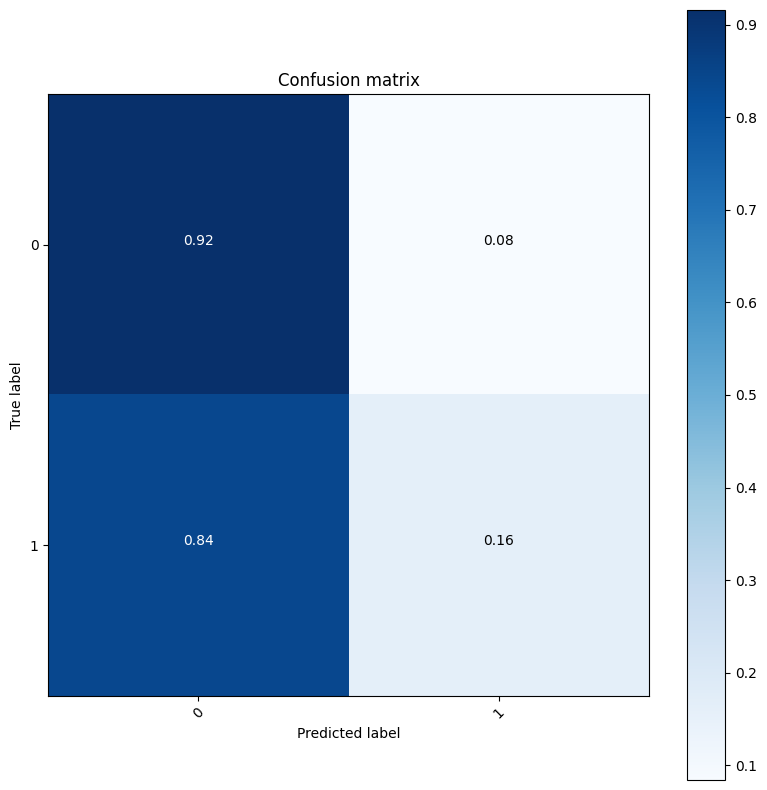

In [100]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


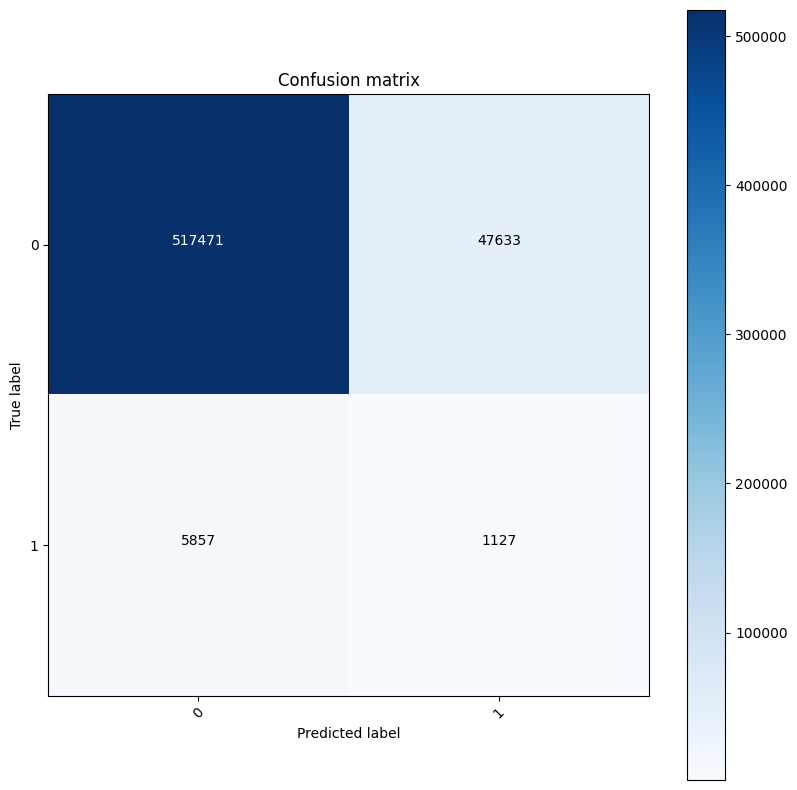

In [37]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Teet visualizations:


In [110]:
xyz_list = []
true_labels_list = []
pred_labels_list = []

index = 0
for size in test_file_sizes:  # <- This replaces len(X_test) guesswork
    xyz = X_test_combined[index:index + size]
    true_labels = y_test_combined[index:index + size]
    preds = all_preds[index:index + size]

    if len(true_labels) != len(preds):
        print(f"WARNING: Mismatch at index {index}")
        print(f"  Labels: {len(true_labels)}")
        print(f"  Preds:  {len(preds)}")

    xyz_list.append(xyz)
    true_labels_list.append(true_labels)
    pred_labels_list.append(preds)

    index += size


In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hillfort_true_positives_per_file(xyz_list, true_labels_list, pred_labels_list, max_files=10):
    """
    Visualizes correctly predicted hillforts per file, now with actual visible dots and feedback.
    """
    num_files = min(len(xyz_list), max_files)
    cols = 2
    rows = (num_files + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    axes = axes.flatten()

    for i in range(num_files):
        xyz = xyz_list[i]
        true = np.array(true_labels_list[i])
        pred = np.array(pred_labels_list[i])

        correct_hillforts = (true == 1) & (pred == 1)
        num_tp = correct_hillforts.sum()

        print(f"File {i+1}: {num_tp} true positive hillforts")

        ax = axes[i]

        if num_tp == 0:
            ax.set_title(f"File {i+1}: No TP Found")
            ax.axis('off')
            continue

        x = xyz[correct_hillforts, 0]
        y = xyz[correct_hillforts, 1]

        ax.scatter(x, y, c='red', s=10, alpha=0.8, edgecolor='black', linewidths=0.2)
        ax.set_title(f"File {i+1}: {num_tp} TP")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis('equal')
        ax.grid(True)

    for j in range(num_tp, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [112]:
total_correct = 0
for i in range(len(xyz_list)):
    true = true_labels_list[i]
    pred = pred_labels_list[i]
    true = np.array(true)
    pred = np.array(pred)
    correct = (true == 1) & (pred == 1)
    count = correct.sum()
    print(f"File {i}: Correct Hillfort Predictions = {count}")
    total_correct += count

print("TOTAL Correct Hillfort Predictions:", total_correct)


File 0: Correct Hillfort Predictions = 3
File 1: Correct Hillfort Predictions = 7
File 2: Correct Hillfort Predictions = 22
File 3: Correct Hillfort Predictions = 14
File 4: Correct Hillfort Predictions = 43
File 5: Correct Hillfort Predictions = 9
File 6: Correct Hillfort Predictions = 22
File 7: Correct Hillfort Predictions = 54
File 8: Correct Hillfort Predictions = 1
File 9: Correct Hillfort Predictions = 15
File 10: Correct Hillfort Predictions = 22
File 11: Correct Hillfort Predictions = 17
File 12: Correct Hillfort Predictions = 0
File 13: Correct Hillfort Predictions = 10
File 14: Correct Hillfort Predictions = 24
File 15: Correct Hillfort Predictions = 46
File 16: Correct Hillfort Predictions = 2
File 17: Correct Hillfort Predictions = 4
File 18: Correct Hillfort Predictions = 7
File 19: Correct Hillfort Predictions = 31
File 20: Correct Hillfort Predictions = 27
File 21: Correct Hillfort Predictions = 0
File 22: Correct Hillfort Predictions = 86
File 23: Correct Hillfort Pred

File 1: 3 true positive hillforts
File 2: 7 true positive hillforts
File 3: 22 true positive hillforts
File 4: 14 true positive hillforts
File 5: 43 true positive hillforts
File 6: 9 true positive hillforts
File 7: 22 true positive hillforts
File 8: 54 true positive hillforts
File 9: 1 true positive hillforts
File 10: 15 true positive hillforts


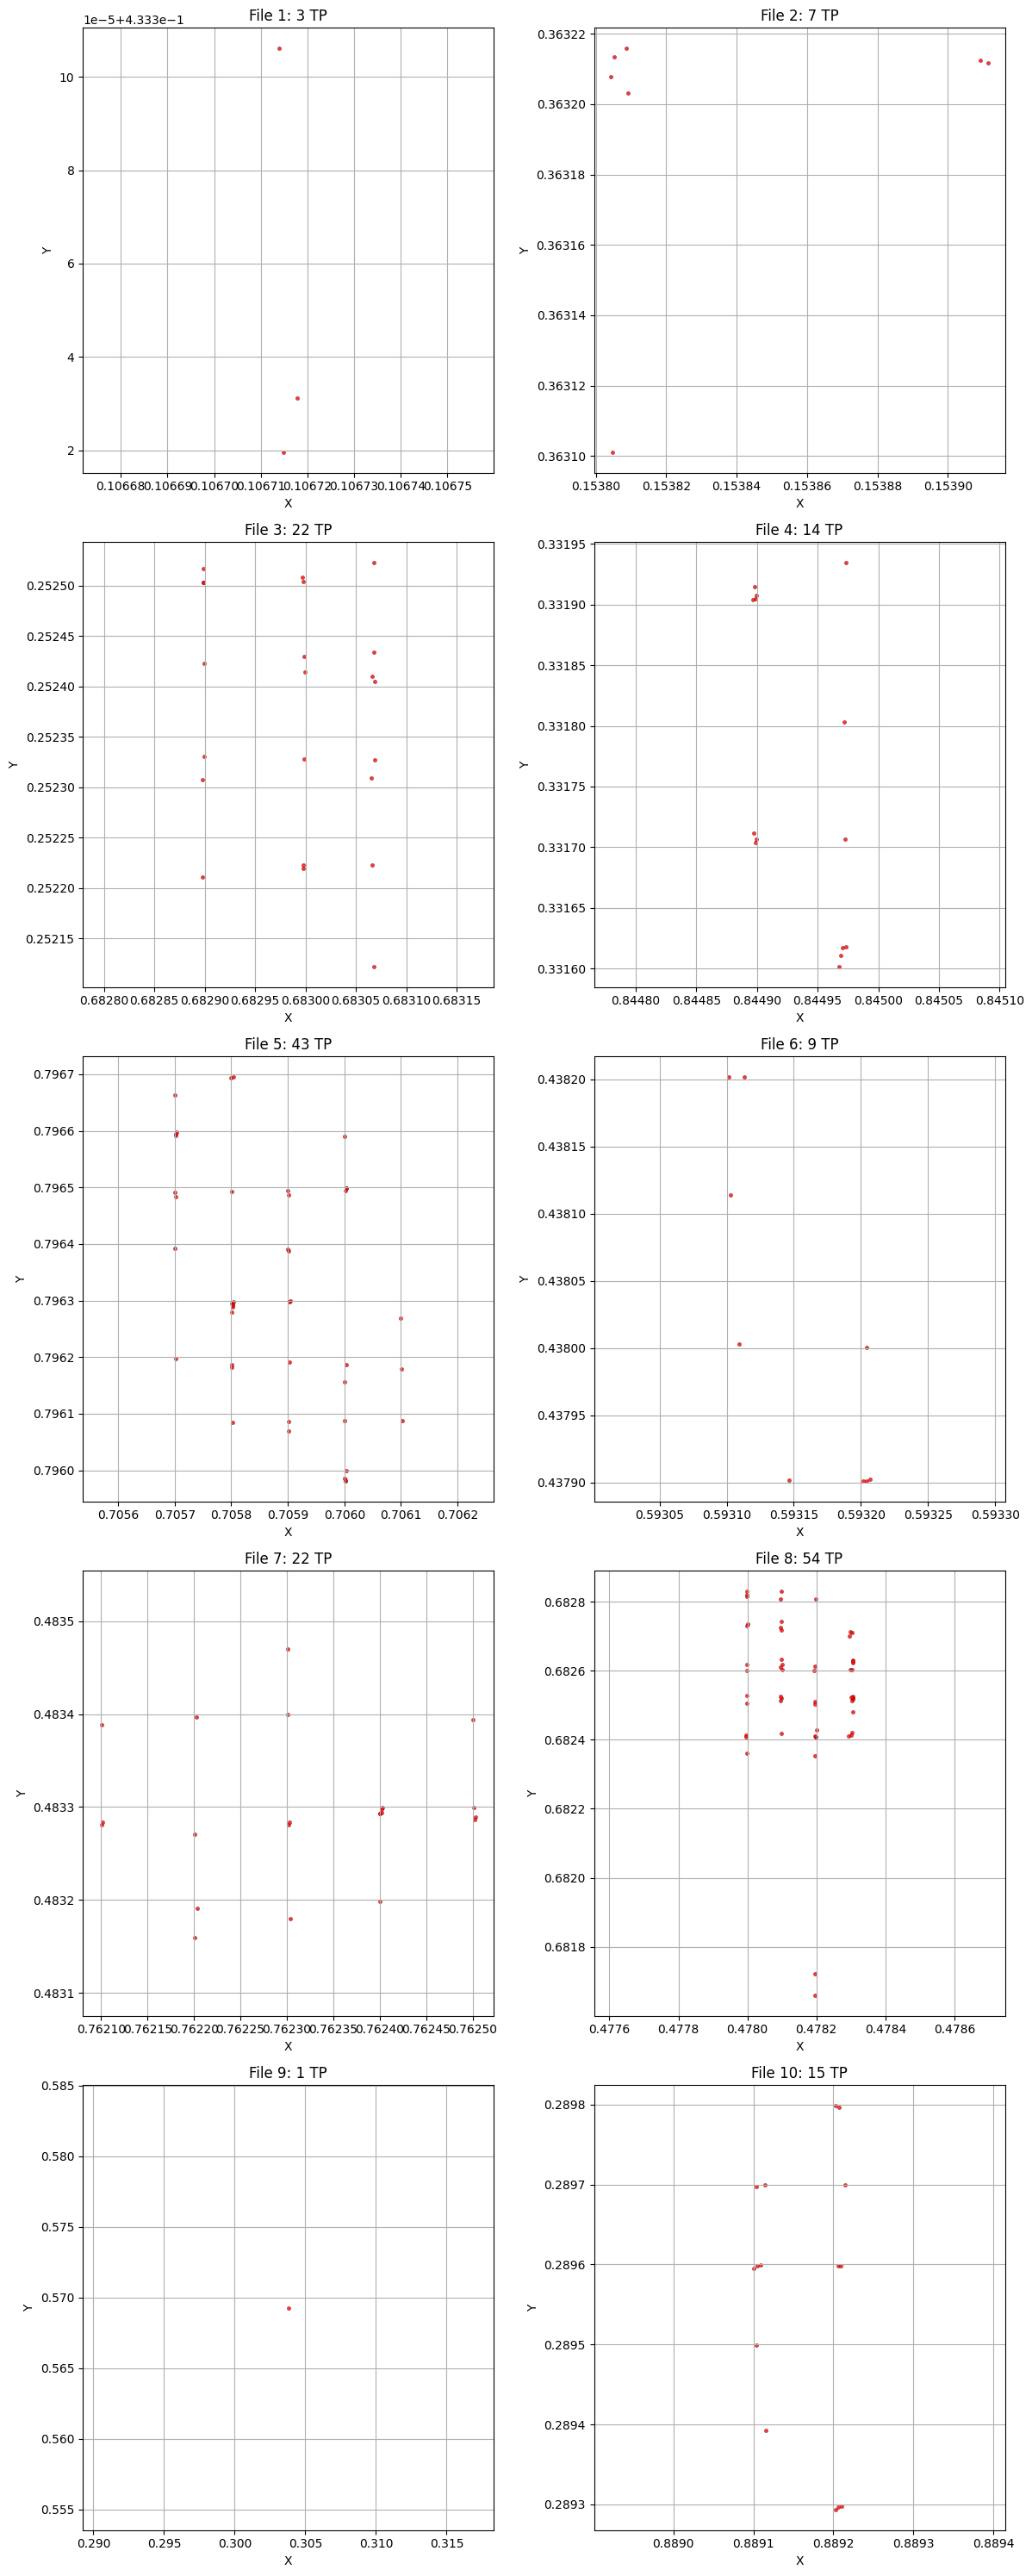

In [113]:
plot_hillfort_true_positives_per_file(xyz_list, true_labels_list, pred_labels_list, max_files=10)


In [69]:
from sklearn.model_selection import train_test_split
import os

laz_file_dir = '../data/downsampled_class_lazFiles/'

# Get sorted list of all files (important for reproducibility!)
all_files = sorted([
    os.path.join(laz_file_dir, f)
    for f in os.listdir(laz_file_dir)
    if f.endswith('.laz')
])

# Split same as before
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

# Now get the filename for test index 26
file_index = 26
print("Test file at index 26:", test_files[file_index])


Test file at index 26: ../data/downsampled_class_lazFiles/506490_2024_tava.laz


In [70]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

# Path to your test .laz file (change this to match test_files[26])
target_file = '../data/downsampled_class_lazFiles/506490_2024_tava.laz'

# Load the .laz file
las = laspy.read(target_file)
points = np.vstack((las.x, las.y, las.z)).T

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]


In [72]:
# Set grid resolution
resolution = 1.0  # 1 meter per pixel
range_x = x.max() - x.min()
range_y = y.max() - y.min()

nbins_x = max(1, int(range_x / resolution))
nbins_y = max(1, int(range_y / resolution))


print(f"x size: {x.shape}, y size: {y.shape}, z size: {z.shape}")
print(f"x range: {x.min()} - {x.max()}, y range: {y.min()} - {y.max()}")
print(f"nbins_x: {nbins_x}, nbins_y: {nbins_y}")


# Create a 2D binned elevation raster
stat, xedges, yedges, _ = binned_statistic_2d(x, y, z, statistic='mean', bins=[nbins_x, nbins_y])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


x size: (21060,), y size: (21060,), z size: (21060,)
x range: 0.33333333 - 0.33595198, y range: 0.49438202200000003 - 0.498127266
nbins_x: 1, nbins_y: 1


In [73]:
# Pull from your pre-sliced xyz/predictions
file_index = 26  # or whatever file index matches
xyz = np.array(xyz_list[file_index])
true = np.array(true_labels_list[file_index])
pred = np.array(pred_labels_list[file_index])

# Get correctly predicted hillfort points
tp_mask = (true == 1) & (pred == 1)
hillfort_pts = xyz[tp_mask]


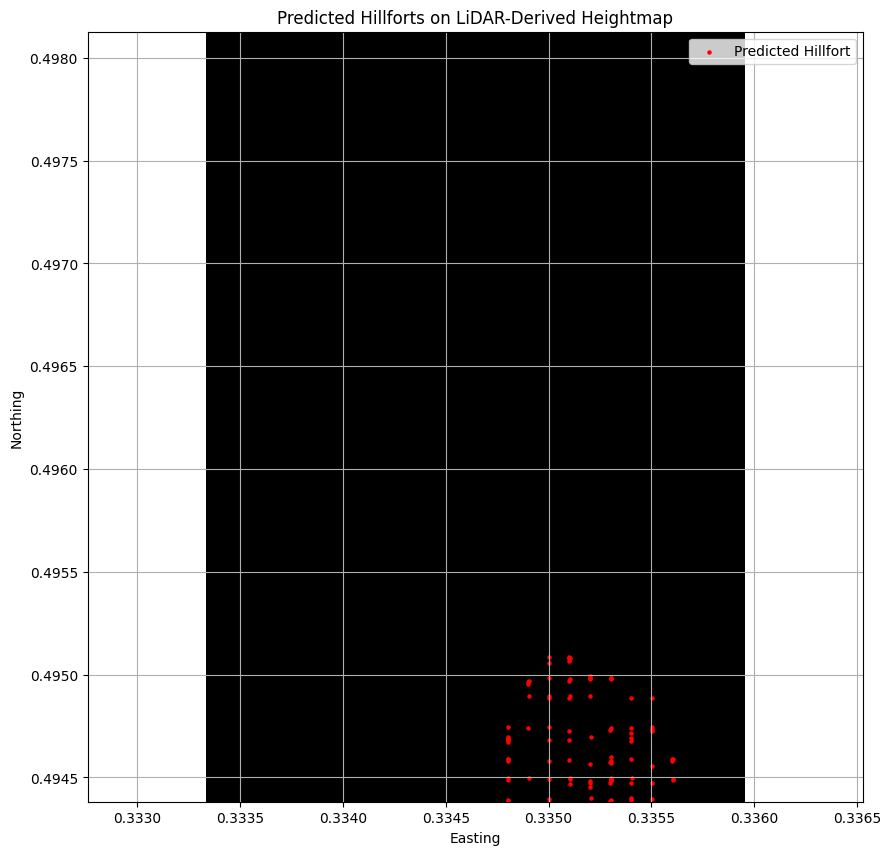

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot heightmap as background
ax.imshow(np.flipud(stat.T), extent=extent, cmap='gray', interpolation='none')

# Plot hillfort predictions as red dots
ax.scatter(hillfort_pts[:, 0], hillfort_pts[:, 1], c='red', s=5, label='Predicted Hillfort')

# Finalize plot
ax.set_title("Predicted Hillforts on LiDAR-Derived Heightmap")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.axis('equal')
ax.legend()
plt.grid(True)
plt.show()


In [75]:
# Rebuild the same test set split to get correct file name
from sklearn.model_selection import train_test_split
import os

input_dir = '../data/downsampled_class_lazFiles'
all_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.laz')])

# Deterministic split to recover file at index 26
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

target_file = test_files[26]
print("Target test file:", target_file)


Target test file: 506490_2024_tava.laz


In [76]:
import laspy
import pandas as pd
import shapely.wkt
import numpy as np

# Load the .laz file
las_path = os.path.join(input_dir, target_file)
las = laspy.read(las_path)

points = np.vstack((las.x, las.y, las.z)).T
x, y, z = points[:, 0], points[:, 1], points[:, 2]

# Load normalized polygons
norm_poly_df = pd.read_csv('../data/normalized_polygons.csv')
norm_poly_df['polygons'] = norm_poly_df['polygons_wkt'].apply(lambda wkt_list: [shapely.wkt.loads(w) for w in eval(wkt_list)])

# Get polygon(s) for this file
matching_row = norm_poly_df[norm_poly_df['laz_file'] == target_file]
hillfort_polys = matching_row['polygons'].values[0] if not matching_row.empty else []


In [77]:
# These come from your earlier model outputs
file_index = 26  # test file index
xyz = np.array(xyz_list[file_index])
true = np.array(true_labels_list[file_index])
pred = np.array(pred_labels_list[file_index])

tp_mask = (true == 1) & (pred == 1)
tp_points = xyz[tp_mask]  # shape (N, 3)


In [78]:
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

resolution = 512  # number of pixels

nbins_x = nbins_y = resolution
stat, xedges, yedges, _ = binned_statistic_2d(x, y, z, statistic='mean', bins=[nbins_x, nbins_y])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


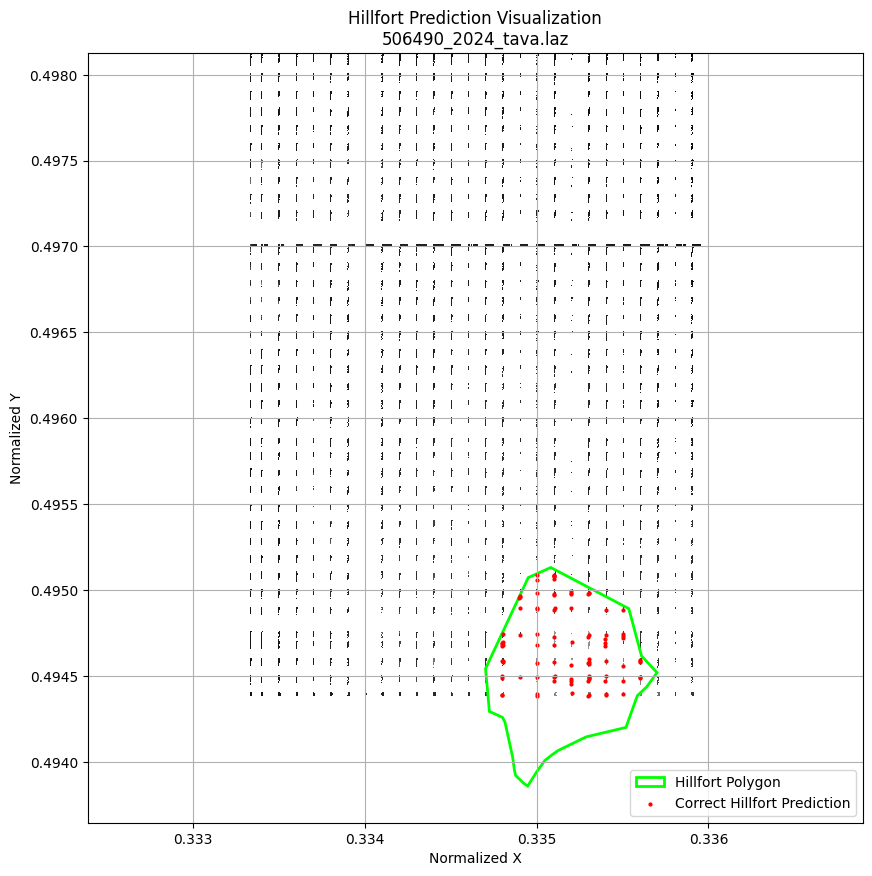

In [79]:
from matplotlib.patches import Polygon as MplPolygon

fig, ax = plt.subplots(figsize=(10, 10))

# Show heightmap
ax.imshow(np.flipud(stat.T), extent=extent, cmap='gray', interpolation='none')

# Overlay polygon(s)
for poly in hillfort_polys:
    patch = MplPolygon(np.array(poly.exterior.coords), closed=True, edgecolor='lime', linewidth=2, facecolor='none', label='Hillfort Polygon')
    ax.add_patch(patch)

# Overlay TP predictions
ax.scatter(tp_points[:, 0], tp_points[:, 1], c='red', s=4, label='Correct Hillfort Prediction')

# Labels & Legend
ax.set_title(f"Hillfort Prediction Visualization\n{target_file}")
ax.set_xlabel("Normalized X")
ax.set_ylabel("Normalized Y")
ax.axis("equal")
ax.legend(loc='lower right')
plt.grid(True)
plt.show()


kood mis proovib 2d graafilise värvilise pildi ja ennustatud hillforti punktid ja polügoni kokku panna.

Visualizing: 490588_2021_tava.laz


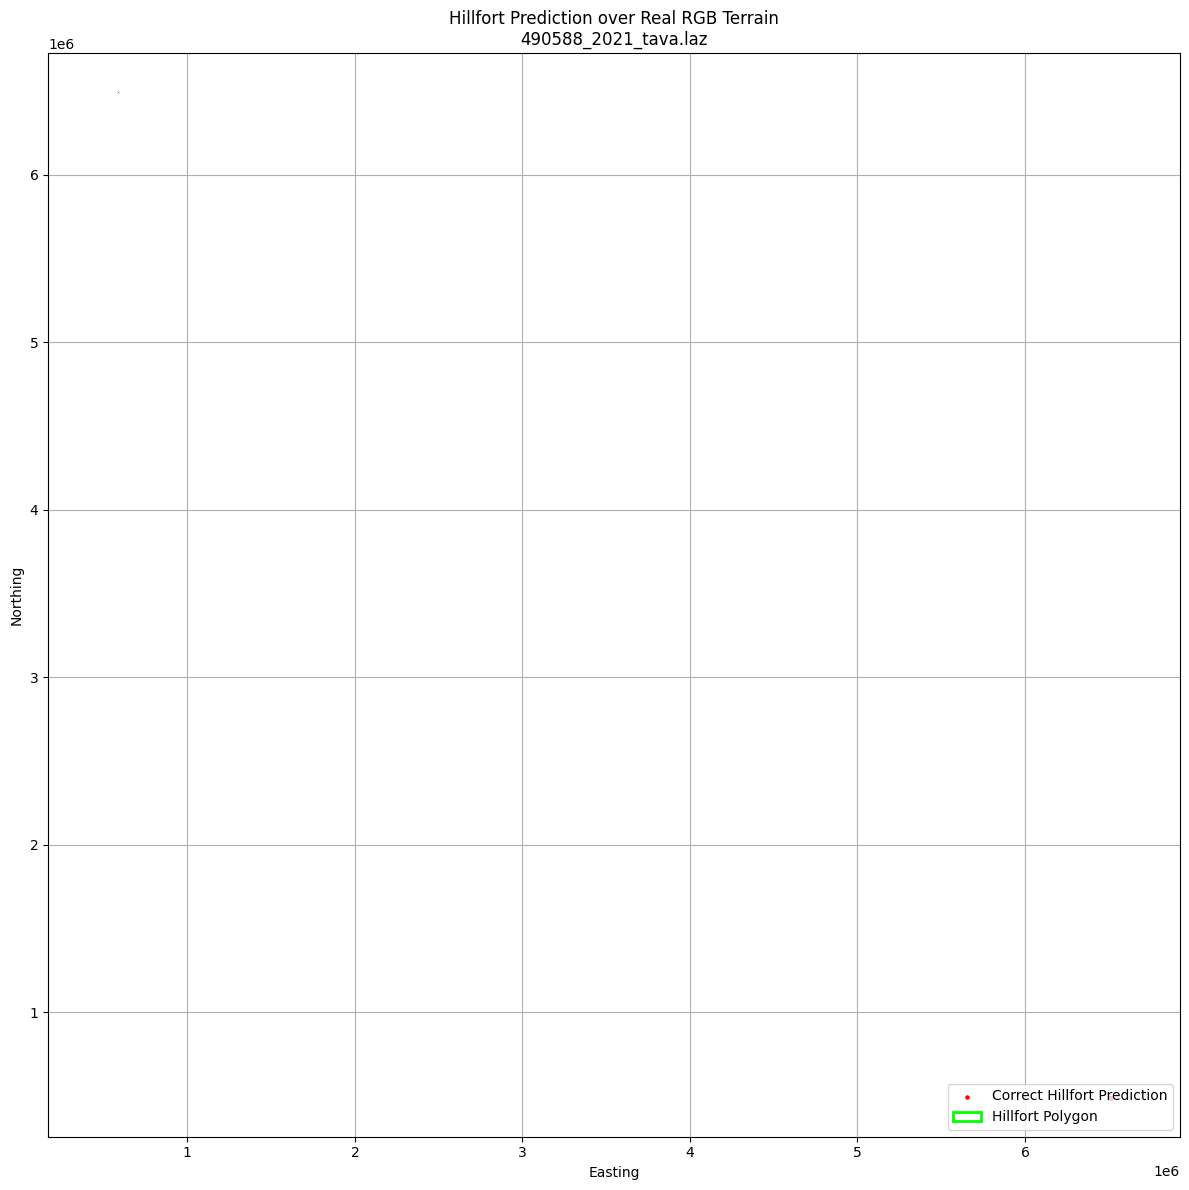

In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import laspy
import pandas as pd
import shapely.wkt
import shapely.affinity

# === CONFIGURATION ===
target_index = 26  # <-- Change this to see different test files
normalized_polygons_csv = "../data/normalized_polygons.csv"
normalized_laz_dir = "../data/normalized_lazFiles/"
original_laz_dir = "../data/lazFiles/"

# These are fixed global constants from your preprocessing
GLOBAL_MIN_X, GLOBAL_MAX_X = 6374000, 6641000
GLOBAL_MIN_Y, GLOBAL_MAX_Y = 364000, 742000
GLOBAL_MIN_Z, GLOBAL_MAX_Z = -125, 320

# === STEP 1: Recreate the test file list ===
all_files = sorted([f for f in os.listdir(original_laz_dir) if f.endswith('.laz')])
from sklearn.model_selection import train_test_split
_, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
test_file = test_files[target_index]
print("Visualizing:", test_file)

# === STEP 2: Load original LAS file for RGB background ===
las_path = os.path.join(original_laz_dir, test_file)
las = laspy.read(las_path)

x = las.x
y = las.y
r = las.red / 65535 * 255
g = las.green / 65535 * 255
b = las.blue / 65535 * 255

# Drop invalid points with no color
valid = (r > 0) & (g > 0) & (b > 0)
x, y, r, g, b = x[valid], y[valid], r[valid], g[valid], b[valid]
rgb_colors = np.stack([r, g, b], axis=1).astype(np.uint8)

# === STEP 3: Load + denormalize hillfort polygons ===
poly_df = pd.read_csv(normalized_polygons_csv)
poly_df['polygons'] = poly_df['polygons_wkt'].apply(lambda lst: [shapely.wkt.loads(p) for p in eval(lst)])
polygon_row = poly_df[poly_df['laz_file'] == test_file]
hillfort_polys = []

if not polygon_row.empty:
    norm_polys = polygon_row['polygons'].values[0]
    for poly in norm_polys:
        unscaled = shapely.affinity.scale(
            poly,
            xfact=(GLOBAL_MAX_Y - GLOBAL_MIN_Y),
            yfact=(GLOBAL_MAX_X - GLOBAL_MIN_X),
            origin=(0, 0)
        )
        translated = shapely.affinity.translate(
            unscaled,
            xoff=GLOBAL_MIN_Y,
            yoff=GLOBAL_MIN_X
        )
        hillfort_polys.append(translated)

# === STEP 4: Load predictions from evaluation
# Make sure these three lists exist from your earlier code:
# xyz_list, true_labels_list, pred_labels_list

xyz = np.array(xyz_list[target_index])
true = np.array(true_labels_list[target_index])
pred = np.array(pred_labels_list[target_index])
tp_mask = (true == 1) & (pred == 1)

tp = xyz[tp_mask]
tp_denorm = np.empty_like(tp)
tp_denorm[:, 0] = tp[:, 1] * (GLOBAL_MAX_X - GLOBAL_MIN_X) + GLOBAL_MIN_X  # Y axis
tp_denorm[:, 1] = tp[:, 0] * (GLOBAL_MAX_Y - GLOBAL_MIN_Y) + GLOBAL_MIN_Y  # X axis
tp_denorm[:, 2] = tp[:, 2] * (GLOBAL_MAX_Z - GLOBAL_MIN_Z) + GLOBAL_MIN_Z  # Z axis


# === STEP 5: Plot everything nicely ===
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor('white')

# Background scatter
ax.scatter(x, y, color=rgb_colors / 255.0, s=1, marker='s', linewidths=0)

# True positive red dots
if len(tp_denorm) > 0:
    ax.scatter(tp_denorm[:, 0], tp_denorm[:, 1], c='red', s=5, label='Correct Hillfort Prediction')

# Green polygon overlay
for poly in hillfort_polys:
    patch = MplPolygon(np.array(poly.exterior.coords), closed=True,
                       edgecolor='lime', linewidth=2, facecolor='none', label='Hillfort Polygon')
    ax.add_patch(patch)

# === STEP 6: Zoom to data ===
buffer = 5  # meters around the data
all_x = np.concatenate([x, tp_denorm[:, 0]]) if len(tp_denorm) > 0 else x
all_y = np.concatenate([y, tp_denorm[:, 1]]) if len(tp_denorm) > 0 else y

ax.set_xlim(all_x.min() - buffer, all_x.max() + buffer)
ax.set_ylim(all_y.min() - buffer, all_y.max() + buffer)

# === Final polish ===
ax.set_title(f"Hillfort Prediction over Real RGB Terrain\n{test_file}")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.axis('equal')
ax.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


veel infot ja meetrikat.

In [119]:
xyz_list = []
true_labels_list = []
pred_labels_list = []

index = 0
for i in range(len(X_test)):  # X_test is still a list of per-file arrays
    xyz = X_test[i]                     # shape: (N_i, 3)
    true_labels = y_test[i]            # shape: (N_i,)
    num_points = len(true_labels)

    preds = all_preds[index:index + num_points]

    if len(preds) != num_points:
        print(f"🚨 Mismatch in file {i}: {len(preds)} != {num_points}")
    
    xyz_list.append(xyz)
    true_labels_list.append(true_labels)
    pred_labels_list.append(preds)

    index += num_points


In [126]:
file_summary = []

start_idx = 0

for i, file_size in enumerate(test_file_sizes):
    end_idx = start_idx + file_size

    # Slice flat arrays safely
    file_labels = np.array(all_labels[start_idx:end_idx])
    file_preds = np.array(all_preds[start_idx:end_idx])
    file_name = test_files[i]

    # Compute metrics
    total_points = file_size
    hillfort_true = np.sum(file_labels == 1)
    hillfort_pred = np.sum(file_preds == 1)
    hillfort_tp = np.sum((file_labels == 1) & (file_preds == 1))

    recall = hillfort_tp / hillfort_true if hillfort_true else 0.0
    precision = hillfort_tp / hillfort_pred if hillfort_pred else 0.0

    file_summary.append({
        "File": file_name,
        "Total Points": total_points,
        "True Hillfort Points": hillfort_true,
        "Predicted Hillfort Points": hillfort_pred,
        "Correct Predictions": hillfort_tp,
        "Recall": recall,
        "Precision": precision
    })

    start_idx = end_idx  # Move to next chunk

summary_df = pd.DataFrame(file_summary)
summary_df.to_csv("hillfort_model_summary_clean.csv", index=False)
summary_df.head(27)


,File,Total Points,True Hillfort Points,Predicted Hillfort Points,Correct Predictions,Recall,Precision
0,577646_2022_tava.laz,20520,254,1684,52,0.204724,0.030879
1,477444_2021_tava.laz,20520,240,1773,28,0.116667,0.015792
2,591669_2022_tava.laz,20520,255,1724,37,0.145098,0.021462
3,437647_2023_tava.laz,21021,268,1803,32,0.119403,0.017748
4,535554_2024_tava.laz,20520,257,1832,50,0.194553,0.027293
5,431611_2023_tava.laz,21826,274,1890,48,0.175182,0.025397
6,503569_2024_tava.laz,20520,282,1689,44,0.156028,0.026051
7,458644_2023_tava.laz,21280,252,1802,51,0.202381,0.028302
8,510600_2022_tava.laz,21280,247,1834,45,0.182186,0.024537
9,428638_2023_tava.laz,21840,254,1804,27,0.106299,0.014967


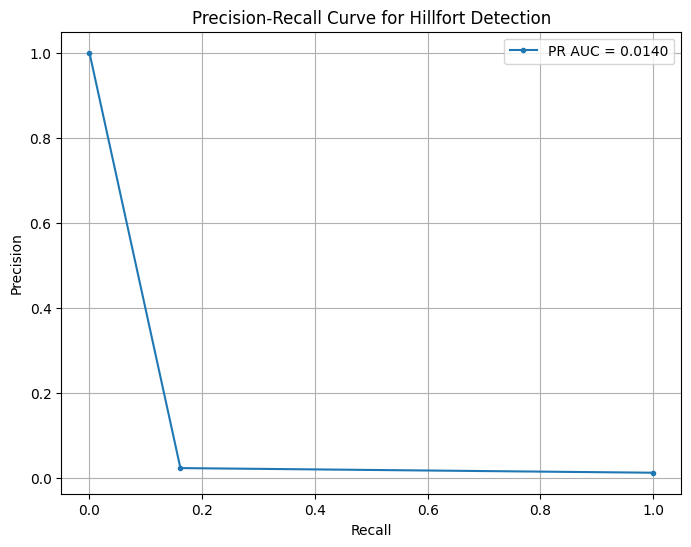

In [128]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
pr_auc = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Hillfort Detection")
plt.grid(True)
plt.legend()
plt.show()


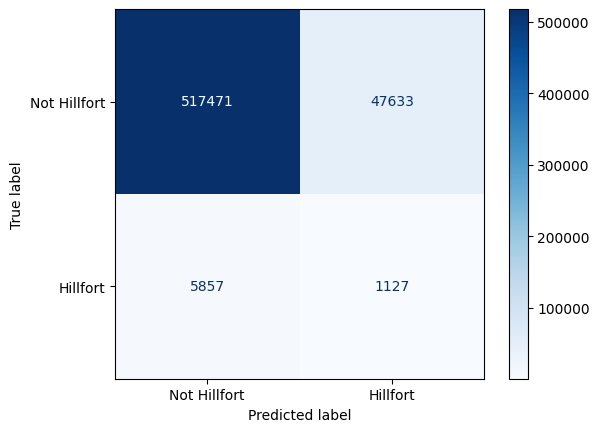

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=["Not Hillfort", "Hillfort"], cmap="Blues")


In [130]:
summary_df["F1 Score"] = 2 * (summary_df["Precision"] * summary_df["Recall"]) / (summary_df["Precision"] + summary_df["Recall"])
summary_df.sort_values("F1 Score", ascending=False).head(5)


,File,Total Points,True Hillfort Points,Predicted Hillfort Points,Correct Predictions,Recall,Precision,F1 Score
23,564508_2024_tava.laz,21060,248,1869,58,0.233871,0.031033,0.054795
0,577646_2022_tava.laz,20520,254,1684,52,0.204724,0.030879,0.053664
25,441622_2023_tava.laz,21840,287,1831,54,0.188153,0.029492,0.050992
10,444670_2023_tava.laz,21060,259,1805,52,0.200772,0.028809,0.050388
7,458644_2023_tava.laz,21280,252,1802,51,0.202381,0.028302,0.049659


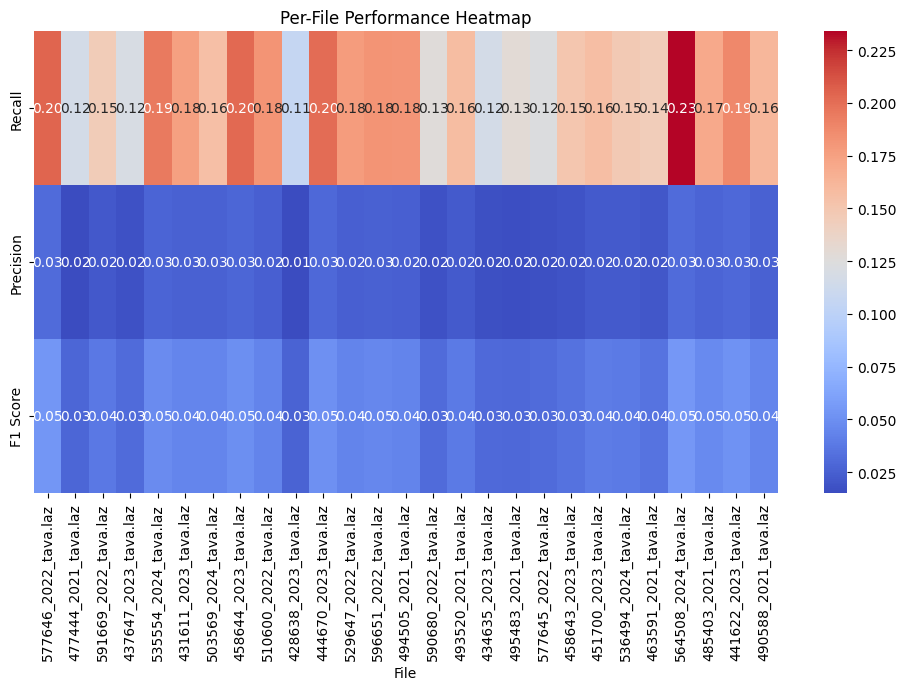

In [131]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(summary_df[["Recall", "Precision", "F1 Score"]].set_index(summary_df["File"]).T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Per-File Performance Heatmap")
plt.show()


Testing on lidar data that has hills or dumpsite, but no hillforts

In [32]:
test_lases = os.listdir('../data/downsampled_class_lazFiles/')

In [33]:
X_test_2, y_test_2 = [], []
for las_file in test_lases:
    las = laspy.read(os.path.join('../data/downsampled_class_lazFiles/', las_file))
    xyz = las.xyz
    labels = np.zeros(len(xyz))  # Hillfort class
    X_test_2.append(xyz)
    y_test_2.append(labels)
X_testing = np.vstack(X_test_2)
y_testing = np.concatenate(y_test_2)

In [34]:
print(X_testing.shape)
print(y_testing.shape)

(2758513, 3)
(2758513,)


In [35]:
testing_X = torch.from_numpy(X_testing)
testing_y = torch.from_numpy(y_testing).long()

Setting up splits for model

In [36]:
testing_dataset = PointCloudDataset(testing_X, testing_y)

In [37]:
testing_loader = DataLoader(testing_dataset, batch_size=128, shuffle=True)

In [38]:
all_labels_test, all_preds_test = evaluate_model(model, testing_loader, device)

Batch [  10 / 21551]
Batch [  20 / 21551]
Batch [  30 / 21551]
Batch [  40 / 21551]
Batch [  50 / 21551]
Batch [  60 / 21551]
Batch [  70 / 21551]


KeyboardInterrupt: 

In [128]:
xyz = testing_loader.dataset.xyz.numpy()  # Coordinates (Nx3 array)
labels = testing_loader.dataset.labels.numpy()  # Ground truth labels (N array)
preds = np.array(all_preds_test)  # Predictions (N array)

data_df = pd.DataFrame({
    'x': xyz[:, 0],  # Extract x-coordinate
    'y': xyz[:, 1],  # Extract y-coordinate
    'z': xyz[:, 2],  # Extract z-coordinate
    'true_label': labels,  # Ground truth labels
    'pred_label': preds,   # Predicted labels
})

data_df.to_parquet('../data/test_results_2.parquet', engine='pyarrow', index=False)

In [127]:
cm_test = confusion_matrix(all_labels_test, all_preds_test);
cm_test

array([[388875, 136742],
       [     0,      0]], dtype=int64)

A huge amount of Type I errors, which means that the model couldn't get the spatial context of the hillfort in the downsampled data.

## End